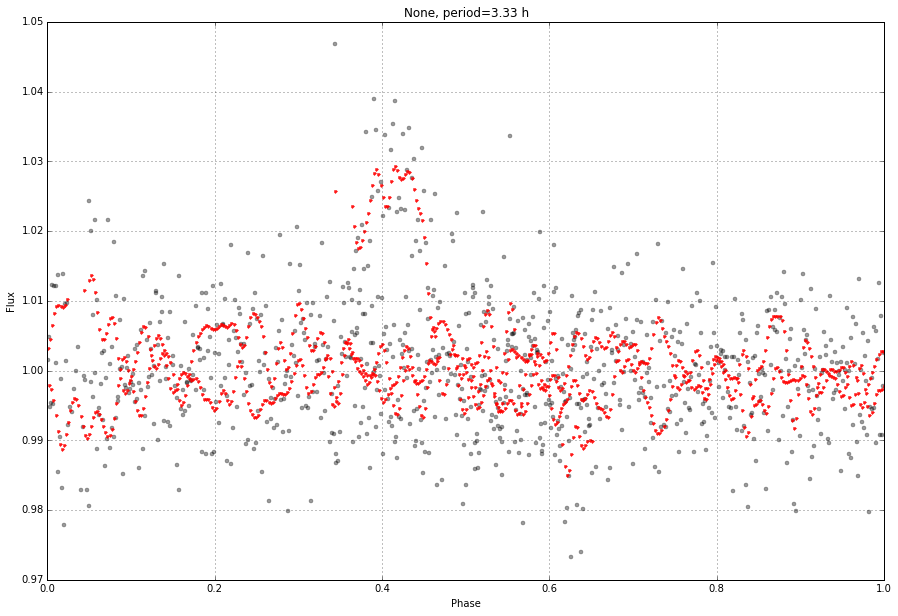

In [22]:
%matplotlib inline
import padre
from padre import LightCurve
import astropy.units as u
from IPython.html.widgets import interact, FloatSlider, RadioButtons, Dropdown, Checkbox
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import os

min_period = 2*u.hour
max_period = 8*u.hour
period_steps = 10*u.min
smooth_kernel = dict(gauss2 = 2,
                     gauss5 = 5)

period_slider = FloatSlider(min=min_period.to(u.day).value, 
                            max=max_period.to(u.day).value,
                            step=period_steps.to(u.day).value, 
                            value=0.5*(min_period + max_period).to(u.day).value)

smoothing_kernel = RadioButtons(options=smooth_kernel.keys())

available_archives = glob("data/*.npz")
file_options = {archive.split(os.sep)[-1]: LightCurve.load_from(archive) 
                for archive in available_archives}
dropdown = Dropdown(options=file_options.keys())

half_period_offset = Checkbox(value=False)

# decorate the plot function with an environment from the UIs:
@interact(kernel=smoothing_kernel, period_days=period_slider, 
          input_file=dropdown, half_period_offset=half_period_offset)
def plot_interactive(period_days, kernel, input_file, half_period_offset):

    lc = file_options[input_file]
    
    fig, ax = plt.subplots(figsize=(15, 10))
    #lc = wolf1516
    t0 = np.mean(lc.times.jd)
    offset = 0 if not half_period_offset else period_days/2.0
    times = ((lc.times.jd - t0 + offset) % period_days) / period_days
    fluxes = lc.fluxes
    smoothed_fluxes = gaussian_filter(lc.fluxes, smooth_kernel[kernel])
    
    ax.grid()
    ax.plot(times, fluxes, 'ko', markersize=4, alpha=0.4)
    ax.plot(times, smoothed_fluxes, 'r.', lw=2, alpha=0.9)
    ax.set(xlabel='Phase', ylabel='Flux',
           title="{0}, period={1:.2f}".format(lc.name, 
                                              (period_days*u.day).to(u.hour)))
